In [1]:
#%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import pack_vis
import pack_dimer
import pack_vis_sol
import pack_cost
import numpy as np
import cupy as cp
import copy
kgs.set_float32(False)

local


np.float64(0.35650769640692814)

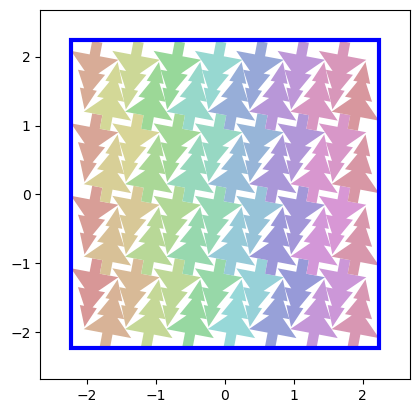

In [2]:
sol = kgs.dill_load(kgs.code_dir + '/../res/opt_practice.pickle')
sol.__class__ = kgs.SolutionCollectionSquare
sol.xyt = sol.xyt.astype(kgs.dtype_cp)
sol.h = sol.h.astype(kgs.dtype_cp)
assert isinstance(sol, kgs.SolutionCollection)
pack_vis_sol.pack_vis_sol(sol)
sol.h[0,0].get()**2/sol.N_trees

In [3]:
%load_ext pyinstrument

In [4]:
import lbfgs_torch_parallel as lbfgs_torch_parallel
import importlib
import pack_ga
importlib.reload(lbfgs_torch_parallel)



stop final relax at some point


<module 'lbfgs_torch_parallel' from '/mnt/d/packing/code/analysis/../core/lbfgs_torch_parallel.py'>

/tmp/ipykernel_56407/3808028136.py:15: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/tmp/ipykernel_56407/3808028136.py:46: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost.toDlpack()), from_dlpack(res.toDlpack())


101 1000.0 [0.22246204957048743 0.26189393826260543 0.23868655493339822
 0.2416039618535995  0.2385089866541083  0.225572491226094
 0.35620490290818185 0.35720766430415796 0.3823703725219385
 0.2437749153560409  0.3042738572909203  0.2843610342908871
 0.2409049947469707  0.25494855228527513 0.4170487606663309
 0.3226634731777723  0.2837120461455256  0.36696521060056575
 0.2931151035118821  0.28871748694876603 0.3031610714881352
 0.23575452750556905 0.2217026090488197  0.27754045416104
 0.22977405589480535 0.2770103528064253  0.23577588528223792
 0.22827845465527186 0.3548832599004079  0.29520461344256105
 0.23204051707593898 0.3050084735605905  0.22651191588258515
 0.31743904732651473 0.3000036131463393  0.3819796319859634
 0.3274916892528643  0.29584586192256684 0.27823115437165336
 0.299807595800026   0.3207599087482576  0.27125197800759215
 0.21817771943022657 0.30327578812593803 0.33733097231943576
 0.22169596708136047 0.2420423343170262  0.4274739215417544
 0.23055078481319047 0.2

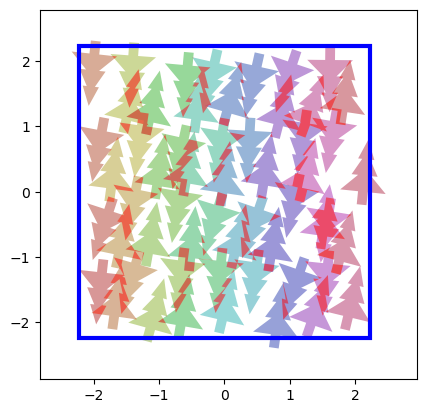

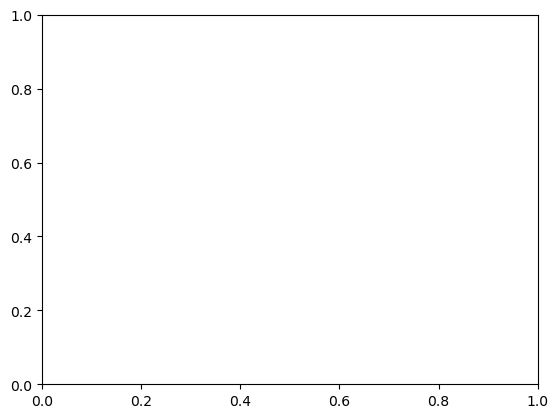

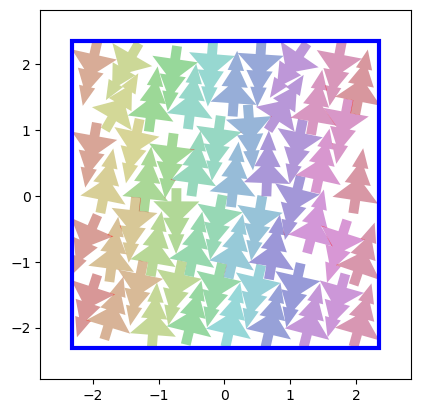

In [5]:
#%%pyinstrument
import matplotlib.pyplot as plt
from IPython.display import HTML, display, clear_output
sol_to_solve = copy.deepcopy(sol)
sol_to_solve.select_ids([1]*1000)
sol_to_solve.xyt += cp.array(np.random.default_rng(seed=42).normal(0,0.1,sol_to_solve.xyt.shape))

sol_tmp = copy.deepcopy(sol_to_solve)

pack_vis_sol.pack_vis_sol(sol_tmp)
    
x0 = cp.concatenate((sol_tmp.xyt.reshape(sol_tmp.N_solutions,-1), sol_tmp.h.reshape(sol_tmp.N_solutions,-1)),axis=1)
from torch.utils.dlpack import to_dlpack, from_dlpack
import numpy as np
x0 = from_dlpack(x0.toDlpack())

counter = 0
counter_n = 0

cost = pack_ga.GA().fine_relaxers[0].cost

fig = plt.figure()
ax = plt.gca()

def f_torch(x, is_main_loop):
    global counter, counter_n
    counter += 1
    counter_n += x.shape[0]
    x=cp.from_dlpack(to_dlpack(x))
    global sol_tmp    
    NN = sol_tmp.N_trees*3
    sol_tmp.xyt = cp.ascontiguousarray(x[:,:NN].reshape(x.shape[0],-1,3))
    sol_tmp.h = cp.ascontiguousarray(x[:,NN:].reshape(x.shape[0],-1))    
    tmp_cost, tmp_grad, tmp_grad_h = cost.compute_cost_allocate(sol_tmp)       
    #tmp_cost, tmp_grad, tmp_grad_h = cost.compute_cost_allocate(sol_tmp)
    res = cp.zeros_like(x)
    res[:,:NN] = tmp_grad.reshape(sol_tmp.N_solutions,-1)
    res[:,NN:] = tmp_grad_h.reshape(sol_tmp.N_solutions,-1)
    #print(tmp_cost)
    # if is_main_loop:
    #     ax.clear()
    #     pack_vis_sol.pack_vis_sol(sol_tmp, solution_idx=0, ax=ax)
    #     ax.set_title(f'{counter}, {tmp_cost[0].get():.8f}, {cp.max(res).get():.8f}')
    #     display(fig)
    #     clear_output(wait=True)     
    return from_dlpack(tmp_cost.toDlpack()), from_dlpack(res.toDlpack())

kgs.debugging_mode = 0
f_torch(x0,False)

kgs.profiling=False
res=lbfgs_torch_parallel.lbfgs(
    f_torch,x0,tolerance_grad=1e-3, tolerance_change=0, max_iter=100, history_size=3, line_search_fn=None, max_step=1e-2
)
x_result = cp.from_dlpack(to_dlpack(res))
#print(x0[0].cpu().item(), x_result[0])

sol_opt = copy.deepcopy(sol_to_solve)
NN = sol_opt.N_trees*3
sol_opt.xyt[...] = x_result[:,:NN].reshape(sol_opt.xyt.shape)
sol_opt.h[...] = x_result[:,NN:].reshape(sol_opt.h.shape)    
pack_vis_sol.pack_vis_sol(sol_opt)
val = cost.compute_cost_allocate(sol_opt)[0].get()
val_np = np.asarray(val)
if val_np.size == 1:
    print(counter, f"{val_np.item():.18e}")
else:
    print(counter, counter_n/counter, np.array2string(val_np, precision=18, floatmode='unique'), np.array2string(np.mean(val_np), precision=18, floatmode='unique'))

stop final relax at some point


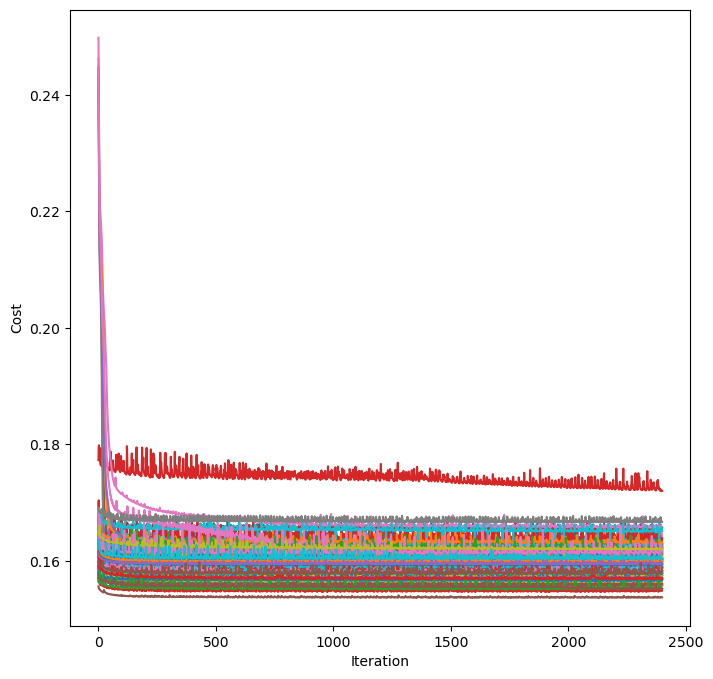

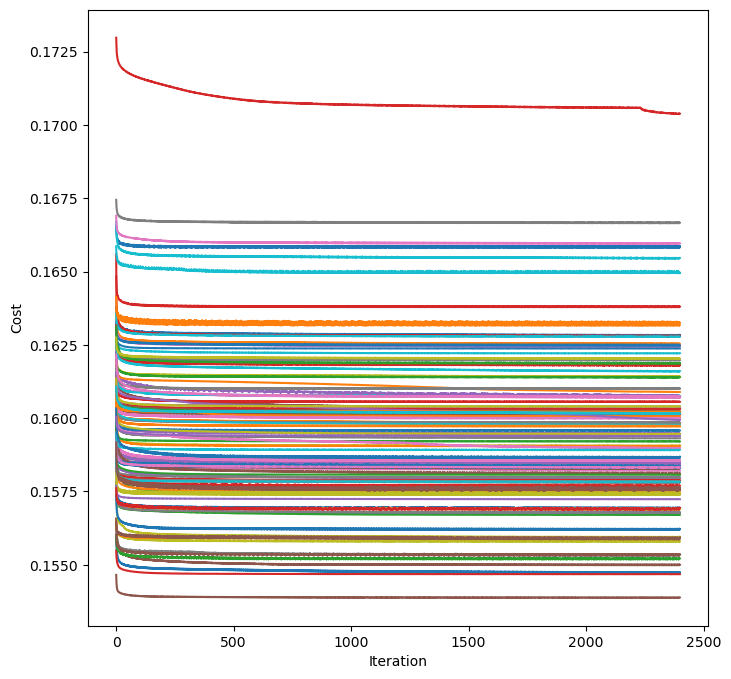

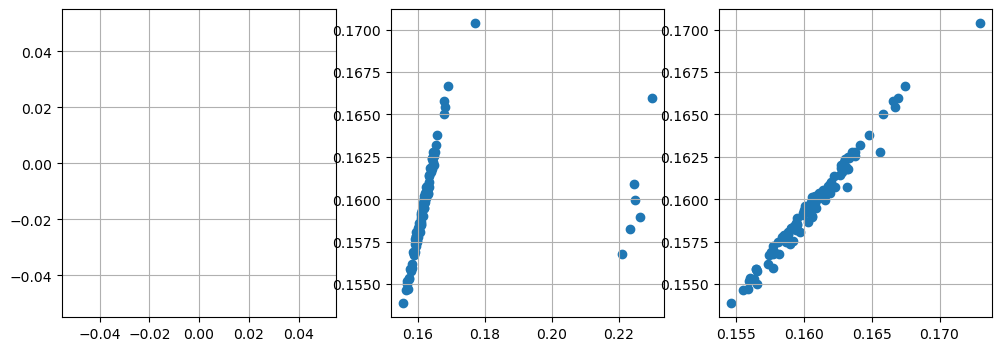

Generation 0, Trees 40, Best cost: 0.15387634, Est: 0.38469086, h: 3.905844
[[3.90584379e+00 6.76550514e-05 1.47052037e-03]]


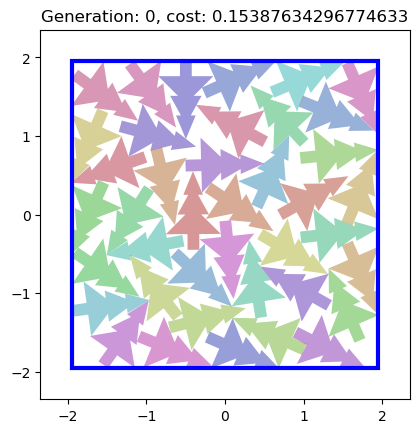

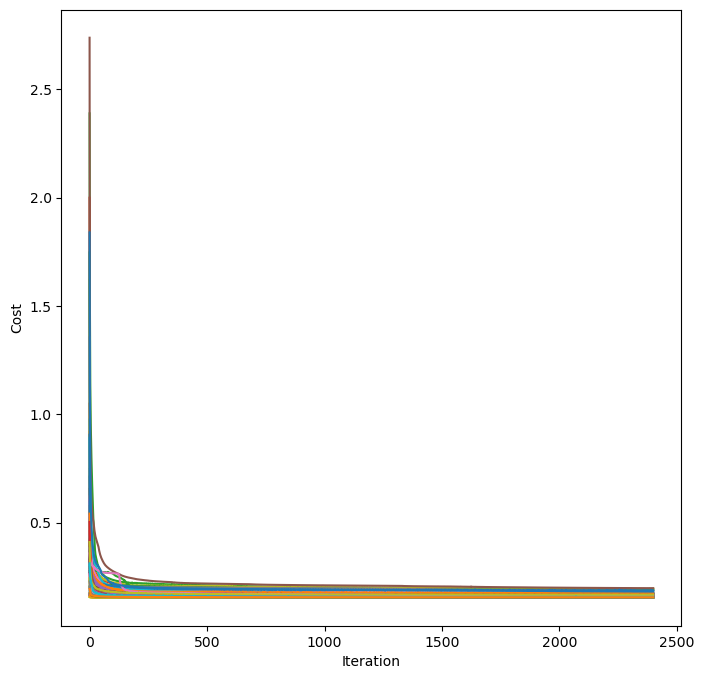

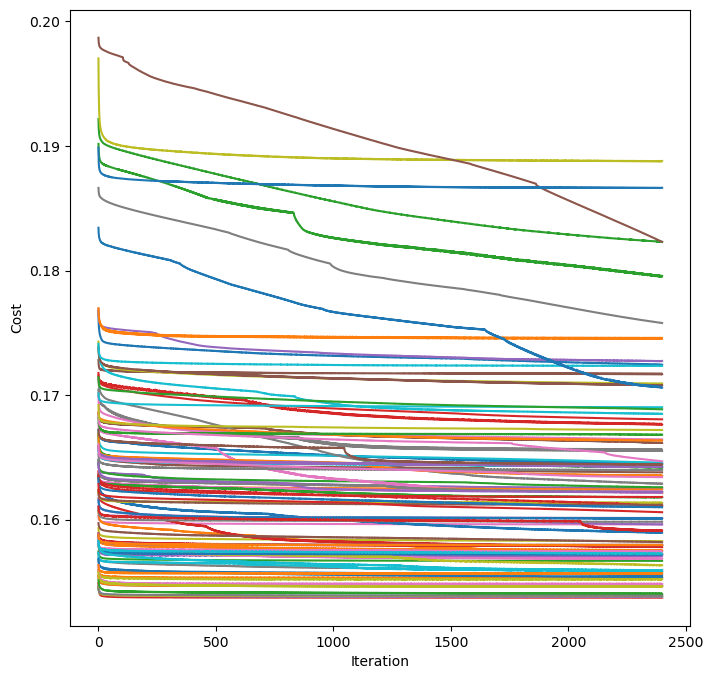

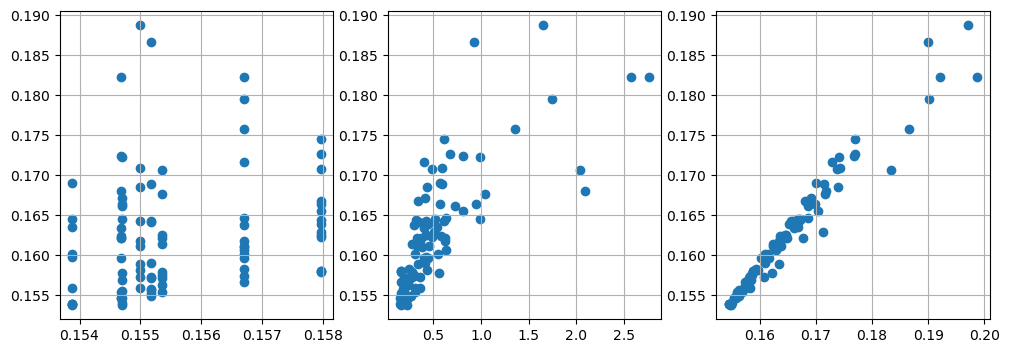

Generation 1, Trees 40, Best cost: 0.15373645, Est: 0.38434112, h: 3.903195
[[3.90319458e+00 9.28281782e-05 6.56310961e-04]]


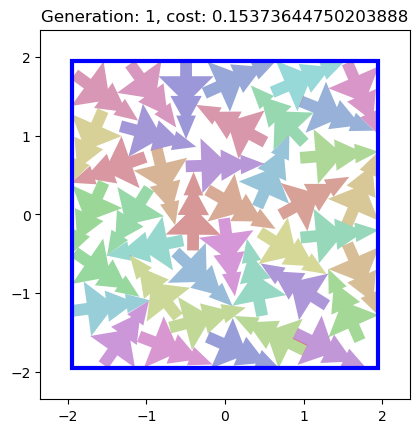

In [ ]:
importlib.reload(pack_ga)
import pack_dynamics
importlib.reload(pack_dynamics)
fastMode = False
runner = pack_ga.GA()
runner.N_trees_to_do = np.array([40])
runner.plot_fitness_predictors = True
runner.plot_diversity_matrix = False
runner.plot_champion = True
runner.n_generations = 2
runner.population_size = 100
runner.selection_size = [1,2,3,4,5,10,20,50]
runner.initializer.jiggler.n_rounds = 1 
#runner.initializer.jiggler.duration_compact /= 10
runner.initializer.jiggler.plot_interval = None
runner.rough_relaxers[0].track_cost = True
runner.rough_relaxers[0].plot_cost = True 
runner.fine_relaxers[0].track_cost = True
runner.fine_relaxers[0].plot_cost = True   
runner.run()

stop final relax at some point


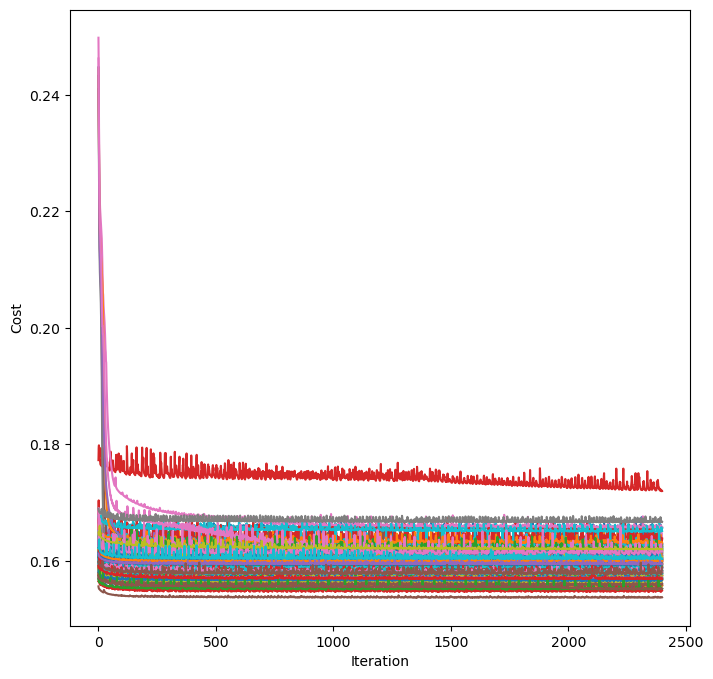

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:59: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:90: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


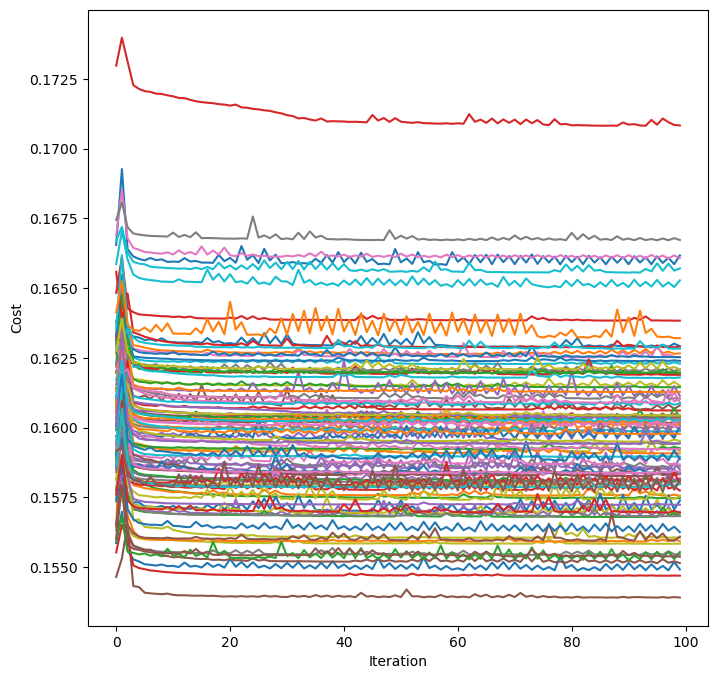

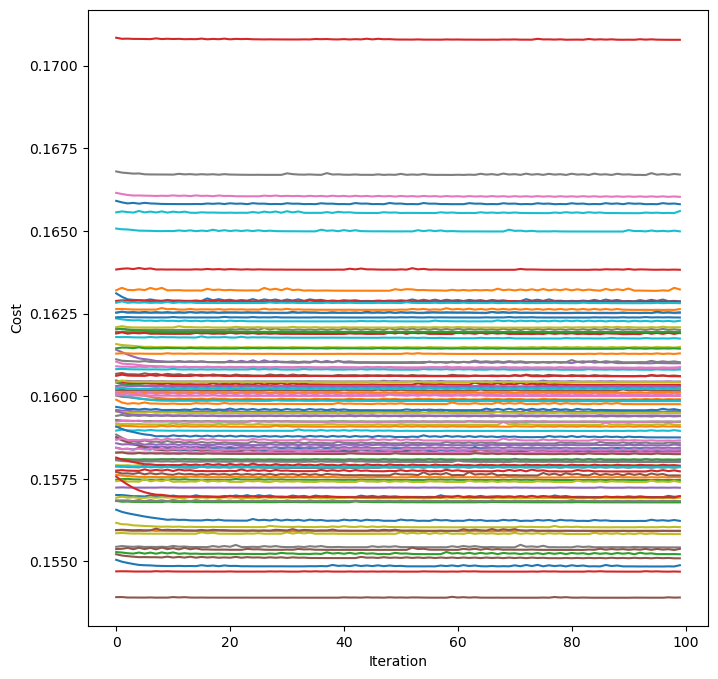

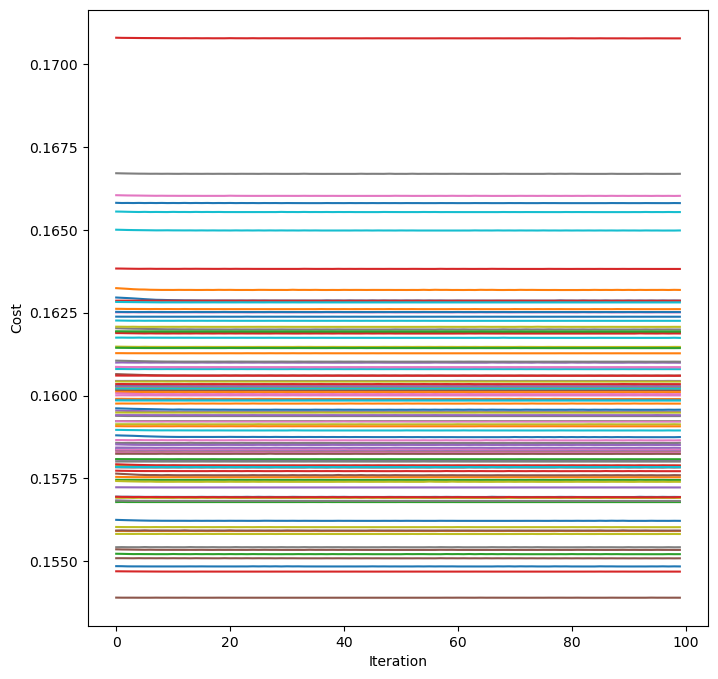

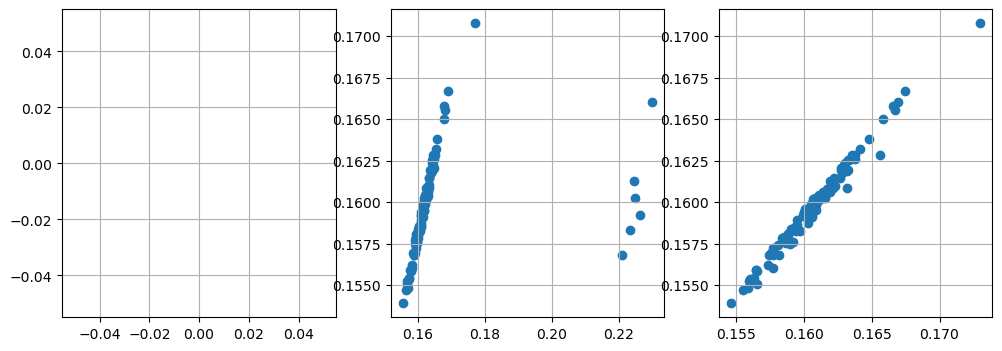

Generation 0, Trees 40, Best cost: 0.15390082, Est: 0.38475205, h: 3.906287
[[ 3.90628733e+00 -1.95782838e-05  1.91972337e-03]]


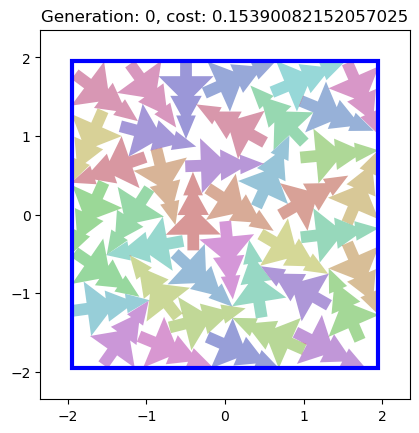

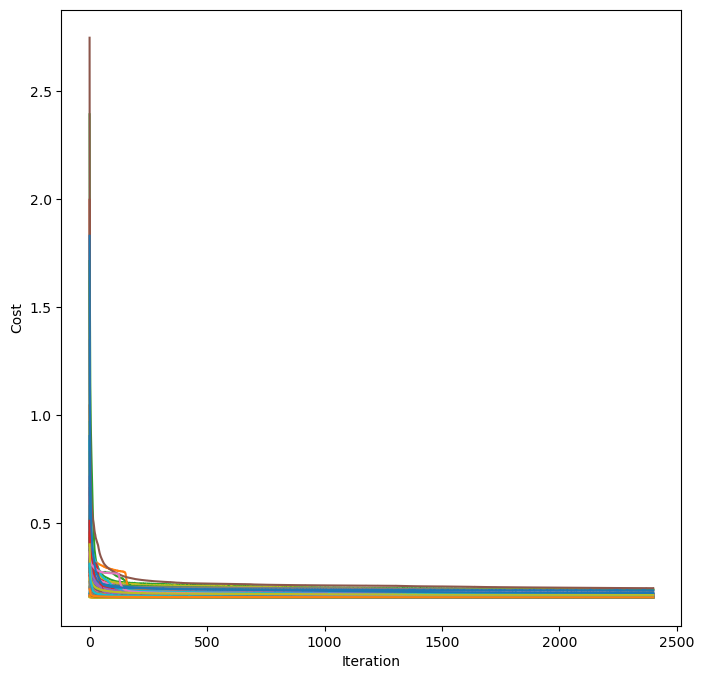

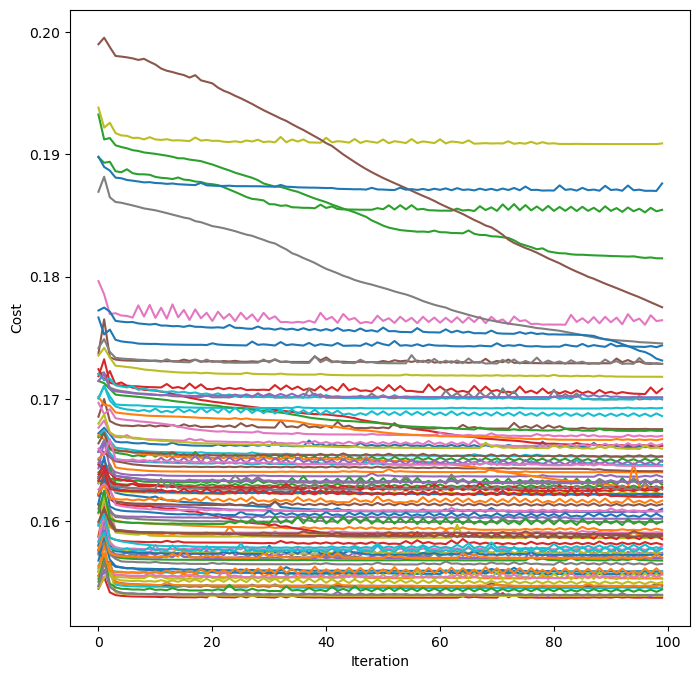

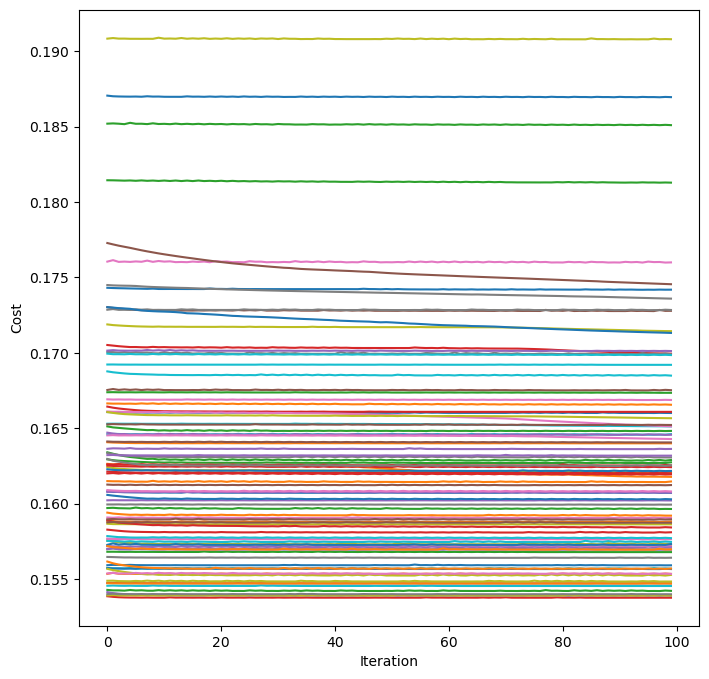

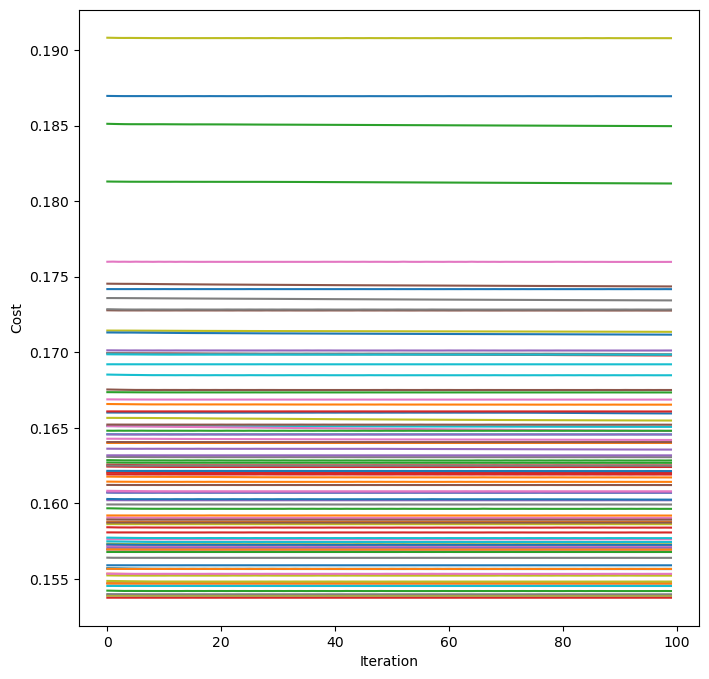

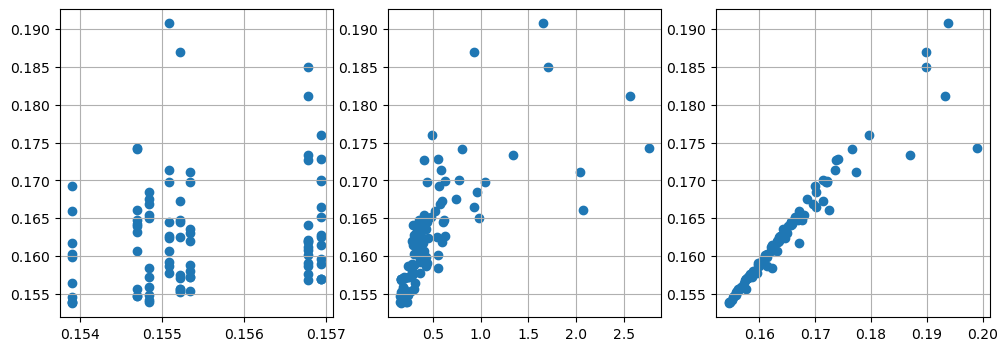

Generation 1, Trees 40, Best cost: 0.15376076, Est: 0.38440190, h: 3.903062
[[ 3.90306219e+00 -3.09091380e-04  7.74083212e-04]]


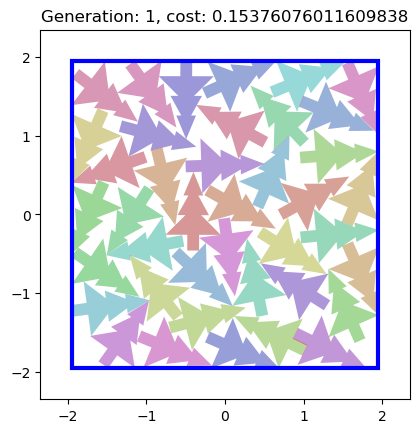

In [27]:
#%matplotlib widget
importlib.reload(pack_ga)
import pack_dynamics
importlib.reload(pack_dynamics)
fastMode = False
runner = pack_ga.GA()
runner.N_trees_to_do = np.array([40])
runner.plot_fitness_predictors = True
runner.plot_diversity_matrix = False
runner.plot_champion = True
runner.n_generations = 2
runner.population_size = 100
runner.selection_size = [1,2,3,4,5,10,20,50]
runner.initializer.jiggler.n_rounds = 1 
#runner.initializer.jiggler.duration_compact /= 10; print('!!!')
#runner.rough_relaxers[0] = pack_dynamics.OptimizerBFGS()
#runner.rough_relaxers[0].cost = pack_ga.GA().rough_relaxers[0].cost
runner.fine_relaxers[0] = pack_dynamics.OptimizerBFGS()
runner.fine_relaxers[0].cost = pack_ga.GA().fine_relaxers[0].cost
runner.fine_relaxers[0].track_cost = True
runner.fine_relaxers[0].plot_cost = True  
runner.fine_relaxers[0].cost.costs[1].smoothing_h = 0.0
runner.fine_relaxers[0].cost.costs[2].smoothing_h = 0.0
runner.fine_relaxers.append(copy.deepcopy(runner.fine_relaxers[0]))
runner.fine_relaxers[1].max_step = 1e-3
runner.fine_relaxers.append(copy.deepcopy(runner.fine_relaxers[0]))
runner.fine_relaxers[2].max_step = 1e-4
runner.fine_relaxers[0].use_line_search = False
runner.rough_relaxers[0].track_cost = True
runner.rough_relaxers[0].plot_cost = True 
#runner.rough_relaxers = [] 
runner.run()

In [8]:
runner.fine_relaxers

[OptimizerBFGS(comment=''),
 OptimizerBFGS(comment=''),
 OptimizerBFGS(comment='')]